In [183]:
from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import playercareerstats, leagueleaders, leaguedashptdefend
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

In [184]:
def get_defensive_leaders(season):
    """Get defensive statistics for potential DPOY candidates for a given season"""
    # Get blocks leaders
    blocks = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='BLK',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    # Get steals leaders
    steals = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='STL',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    # Get defensive rebounds leaders
    def_reb = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='DREB',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    # Combine and process the data
    blocks = blocks[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(15)
    steals = steals[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(15)
    def_reb = def_reb[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(15)
    
    # Combine all leaders and remove duplicates
    all_defenders = pd.concat([blocks, steals, def_reb]).drop_duplicates(subset=['PLAYER'])
    
    # Calculate defensive score (blocks and steals weighted 2x, defensive rebounds 0.5x)
    all_defenders['DEF_SCORE'] = (
        all_defenders['BLK'] * 2 + 
        all_defenders['STL'] * 2 + 
        all_defenders['DREB'] * 0.5
    )
    
    return all_defenders.sort_values('DEF_SCORE', ascending=False).head(10)

def get_last_20_seasons():
    """Calculate the last 20 seasons range"""
    current_year = datetime.now().year
    if datetime.now().month < 10:  # NBA season starts in October
        current_year -= 1
    start_year = current_year - 19  # 20 seasons including the current/last season
    return start_year, current_year

def get_historical_dpoy_candidates():
    """Get defensive leaders for the last 20 seasons"""
    start_year, end_year = get_last_20_seasons()
    all_seasons = []
    
    for year in range(start_year, end_year + 1):
        season = f"{year}-{str(year+1)[-2:]}"
        try:
            season_data = get_defensive_leaders(season)
            season_data['SEASON'] = season
            all_seasons.append(season_data)
            print(f"Processed season {season}")
        except Exception as e:
            print(f"Error processing season {season}: {e}")
    
    return pd.concat(all_seasons)

if __name__ == "__main__":
    start_year, end_year = get_last_20_seasons()
    print(f"\nFetching defensive stats from {start_year}-{start_year+1} to {end_year}-{end_year+1}")
    
    # Get defenders for the last 20 seasons
    historical_defenders = get_historical_dpoy_candidates()
    
    # Display results sorted by season and defensive score
    display_cols = ['SEASON', 'PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'STL', 'DREB', 'DEF_SCORE']
    print("\nTop Defensive Players by Season:")
    print(historical_defenders[display_cols].sort_values(['SEASON', 'DEF_SCORE'], ascending=[False, False]))


Fetching defensive stats from 2005-2006 to 2024-2025
Processed season 2005-06
Processed season 2006-07
Processed season 2007-08
Processed season 2008-09
Processed season 2009-10
Processed season 2010-11
Processed season 2011-12
Processed season 2012-13
Processed season 2013-14
Processed season 2014-15
Processed season 2015-16
Processed season 2016-17
Processed season 2017-18
Processed season 2018-19
Processed season 2019-20
Processed season 2020-21
Processed season 2021-22
Processed season 2022-23
Processed season 2023-24
Processed season 2024-25

Top Defensive Players by Season:
     SEASON             PLAYER TEAM  GP   MIN  BLK  STL  DREB  DEF_SCORE
0   2024-25  Victor Wembanyama  SAS  22  32.5  3.5  1.2   8.2      13.50
2   2024-25      Anthony Davis  LAL  26  35.3  2.2  1.3   9.0      11.50
1   2024-25     Walker Kessler  UTA  20  29.4  2.9  0.5   6.7      10.15
6   2024-25       Nikola Jokić  DEN  22  37.2  0.7  1.8   9.4       9.70
7   2024-25      Jalen Johnson  ATL  26  36.7  

In [185]:
# Historical DPOY top 3 finishers for the last 20 seasons
dpoy_nominees = {
    '2023-24': ['Rudy Gobert', 'Bam Adebayo', 'Victor Wembanyama'],
    '2022-23': ['Jaren Jackson Jr.', 'Brook Lopez', 'Evan Mobley'],
    '2021-22': ['Marcus Smart', 'Mikal Bridges', 'Rudy Gobert'],
    '2020-21': ['Rudy Gobert', 'Ben Simmons', 'Draymond Green'],
    '2019-20': ['Giannis Antetokounmpo', 'Anthony Davis', 'Rudy Gobert'],
    '2018-19': ['Rudy Gobert', 'Paul George', 'Giannis Antetokounmpo'],
    '2017-18': ['Rudy Gobert', 'Joel Embiid', 'Anthony Davis'],
    '2016-17': ['Draymond Green', 'Rudy Gobert', 'Kawhi Leonard'],
    '2015-16': ['Kawhi Leonard', 'Draymond Green', 'Hassan Whiteside'],
    '2014-15': ['Kawhi Leonard', 'Draymond Green', 'DeAndre Jordan'],
    '2013-14': ['Joakim Noah', 'Roy Hibbert', 'DeAndre Jordan'],
    '2012-13': ['Marc Gasol', 'LeBron James', 'Serge Ibaka'],
    '2011-12': ['Tyson Chandler', 'Serge Ibaka', 'Dwight Howard'],
    '2010-11': ['Dwight Howard', 'Kevin Garnett', 'Tyson Chandler'],
    '2009-10': ['Dwight Howard', 'Josh Smith', 'Gerald Wallace'],
    '2008-09': ['Dwight Howard', 'LeBron James', 'Chris Paul'],
    '2007-08': ['Kevin Garnett', 'Marcus Camby', 'Bruce Bowen'],
    '2006-07': ['Marcus Camby', 'Bruce Bowen', 'Tim Duncan'],
    '2005-06': ['Ben Wallace', 'Bruce Bowen', 'Ron Artest'],
    '2004-05': ['Ben Wallace', 'Marcus Camby', 'Kevin Garnett']
}

def get_season_stats(season):
    """Get defensive statistics for all players in a season"""
    try:
        # Get top 100 players in each statline
        blocks = leagueleaders.LeagueLeaders(
            season=season,
            stat_category_abbreviation='BLK',
            per_mode48='PerGame'
        ).get_data_frames()[0]
        
        steals = leagueleaders.LeagueLeaders(
            season=season,
            stat_category_abbreviation='STL',
            per_mode48='PerGame'
        ).get_data_frames()[0]
        
        def_reb = leagueleaders.LeagueLeaders(
            season=season,
            stat_category_abbreviation='DREB',
            per_mode48='PerGame'
        ).get_data_frames()[0]
        
        # Combine stats and remove duplicates
        all_players = pd.concat([
            blocks[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']],
            steals[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']],
            def_reb[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']]
        ]).drop_duplicates(subset=['PLAYER'])
        
        # Add nomination status
        all_players['IS_NOMINEE'] = all_players['PLAYER'].isin(dpoy_nominees[season]).astype(int)
        
        return all_players
    
    except Exception as e:
        print(f"Error getting stats for season {season}: {e}")
        return None

def analyze_nomination_correlations():
    """Analyze correlations between defensive stats and DPOY nomination"""
    all_seasons = []
    
    for season in dpoy_nominees.keys():
        season_data = get_season_stats(season)
        if season_data is not None:
            season_data['SEASON'] = season
            all_seasons.append(season_data)
            print(f"Processed season {season}")
    
    # Combine all seasons
    df = pd.DataFrame(pd.concat(all_seasons))
    
    # Calculate correlations
    stats_cols = ['BLK', 'STL', 'DREB', 'GP', 'MIN']
    
    correlations = df[stats_cols + ['IS_NOMINEE']].corr()['IS_NOMINEE'].drop('IS_NOMINEE')
    
    return df, correlations

if __name__ == "__main__":
    df, correlations = analyze_nomination_correlations()
    
    print("\nCorrelations with DPOY Nomination:")
    for stat, score in correlations.abs().sort_values(ascending=False).items():
        print(f"{stat}: {score:.3f}")
    
    # Compare average stats between nominees and non-nominees
    print("\nAverage Stats Comparison:")
    stats = ['BLK', 'STL', 'DREB', 'GP', 'MIN']
    
    comparison = df.groupby('IS_NOMINEE')[stats].mean()
    print(comparison)

Processed season 2023-24
Processed season 2022-23
Processed season 2021-22
Processed season 2020-21
Processed season 2019-20
Processed season 2018-19
Processed season 2017-18
Processed season 2016-17
Processed season 2015-16
Processed season 2014-15
Processed season 2013-14
Processed season 2012-13
Processed season 2011-12
Processed season 2010-11
Processed season 2009-10
Processed season 2008-09
Processed season 2007-08
Processed season 2006-07
Processed season 2005-06
Processed season 2004-05

Correlations with DPOY Nomination:
BLK: 0.282
DREB: 0.240
MIN: 0.117
STL: 0.109
GP: 0.031

Average Stats Comparison:
                 BLK       STL      DREB         GP        MIN
IS_NOMINEE                                                    
0           0.516957  0.815916  3.487435  72.039620  26.075979
1           1.784483  1.200000  7.322414  74.172414  33.418966


Processed season 2023-24
Processed season 2022-23
Processed season 2021-22
Processed season 2020-21
Processed season 2019-20
Processed season 2018-19
Processed season 2017-18
Processed season 2016-17
Processed season 2015-16
Processed season 2014-15
Processed season 2013-14
Processed season 2012-13
Processed season 2011-12
Processed season 2010-11
Processed season 2009-10
Processed season 2008-09
Processed season 2007-08
Processed season 2006-07
Processed season 2005-06
Processed season 2004-05


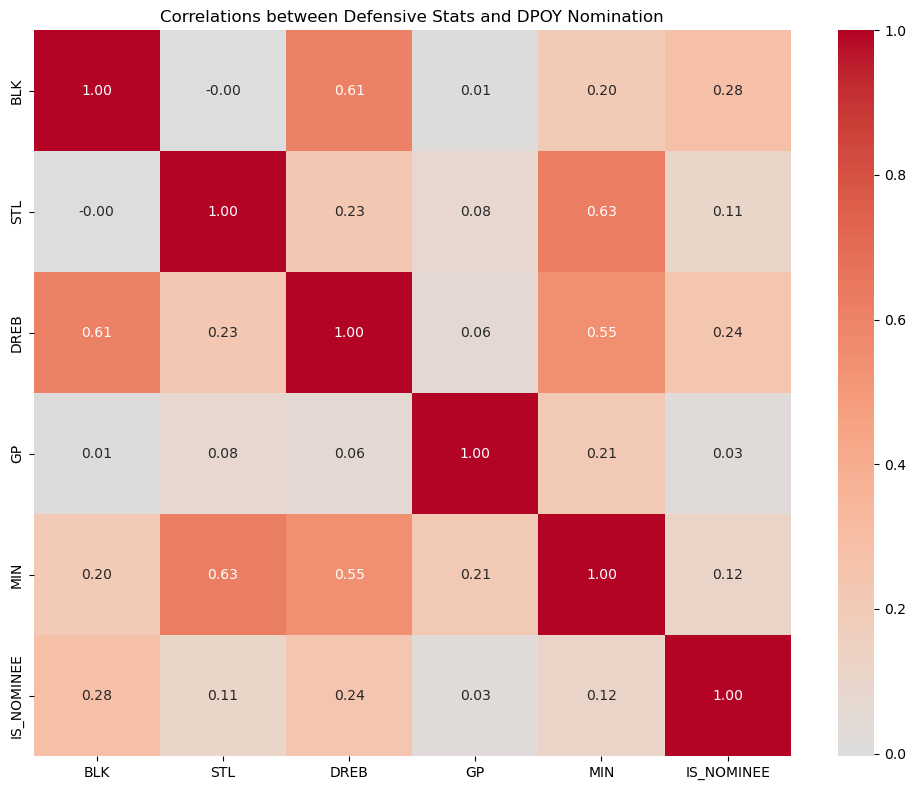

In [186]:
#Get Data
df, correlations = analyze_nomination_correlations()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[['BLK', 'STL', 'DREB', 'GP', 'MIN', 'IS_NOMINEE']].corr(), 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Blue-red diverging colormap
            center=0,  # Center the colormap at 0
            fmt='.2f')  # Show 2 decimal places
plt.title('Correlations between Defensive Stats and DPOY Nomination')
plt.tight_layout()
plt.show()

Processed season 2023-24
Processed season 2022-23
Processed season 2021-22
Processed season 2020-21
Processed season 2019-20
Processed season 2018-19
Processed season 2017-18
Processed season 2016-17
Processed season 2015-16
Processed season 2014-15
Processed season 2013-14
Processed season 2012-13
Processed season 2011-12
Processed season 2010-11
Processed season 2009-10
Processed season 2008-09
Processed season 2007-08
Processed season 2006-07
Processed season 2005-06
Processed season 2004-05


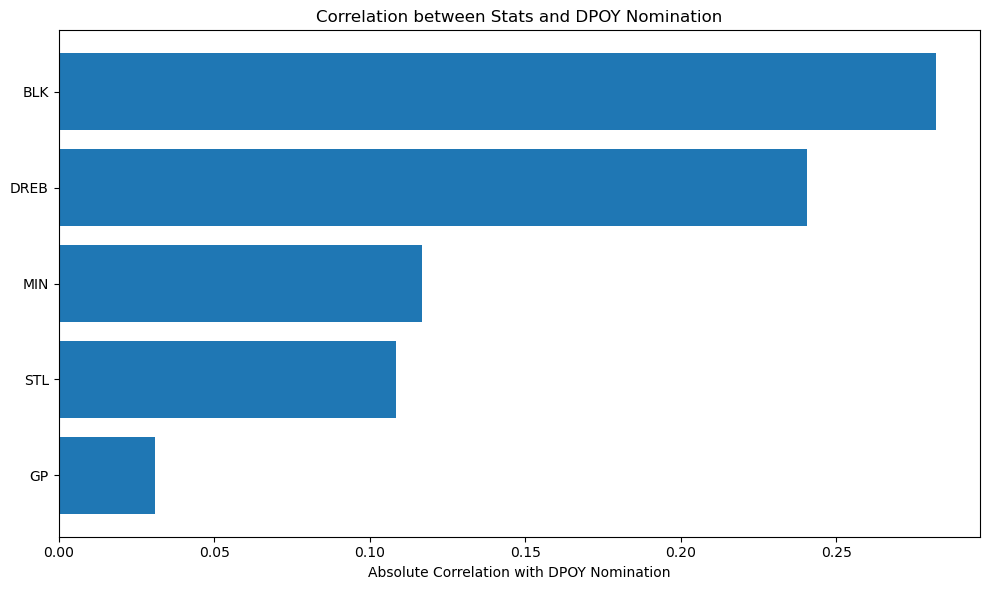

In [187]:
# Get data
df, correlations = analyze_nomination_correlations()

# Create bar plot
plt.figure(figsize=(10, 6))
corr_sorted = correlations.abs().sort_values(ascending=True)
plt.barh(range(len(corr_sorted)), corr_sorted.values)
plt.yticks(range(len(corr_sorted)), corr_sorted.index)
plt.xlabel('Absolute Correlation with DPOY Nomination')
plt.title('Correlation between Stats and DPOY Nomination')
plt.tight_layout()
plt.show()

In [188]:
FEATURES = ['BLK', 'STL', 'DREB', 'GP', 'MIN', 'DEF_SCORE']

# Historical DPOY nominees dictionary
actual_nominees = {
    '2019-20': ['Giannis Antetokounmpo', 'Anthony Davis', 'Rudy Gobert', 'Ben Simmons', 'Bam Adebayo'],
    '2018-19': ['Rudy Gobert', 'Paul George', 'Giannis Antetokounmpo', 'Myles Turner', 'Joel Embiid'],
    '2017-18': ['Rudy Gobert', 'Joel Embiid', 'Anthony Davis', 'Draymond Green', 'Al Horford'],
    '2016-17': ['Draymond Green', 'Rudy Gobert', 'Kawhi Leonard', 'Hassan Whiteside', 'Anthony Davis'],
    '2015-16': ['Kawhi Leonard', 'Draymond Green', 'Hassan Whiteside', 'DeAndre Jordan', 'Paul Millsap'],
    '2014-15': ['Kawhi Leonard', 'Draymond Green', 'DeAndre Jordan', 'Anthony Davis', 'Rudy Gobert'],
    '2013-14': ['Joakim Noah', 'Roy Hibbert', 'DeAndre Jordan', 'Serge Ibaka', 'Andre Iguodala'],
    '2012-13': ['Marc Gasol', 'LeBron James', 'Serge Ibaka', 'Joakim Noah', 'Tony Allen'],
    '2011-12': ['Tyson Chandler', 'Serge Ibaka', 'Dwight Howard', 'Kevin Garnett', 'Andre Iguodala'],
    '2010-11': ['Dwight Howard', 'Kevin Garnett', 'Tyson Chandler', 'Tony Allen', 'Rajon Rondo'],
    '2009-10': ['Dwight Howard', 'Josh Smith', 'Gerald Wallace', 'Anderson Varejao', 'Thabo Sefolosha'],
    '2008-09': ['Dwight Howard', 'LeBron James', 'Kobe Bryant', 'Kevin Garnett', 'Shane Battier'],
    '2007-08': ['Kevin Garnett', 'Marcus Camby', 'Bruce Bowen', 'Tim Duncan', 'Shane Battier'],
    '2006-07': ['Marcus Camby', 'Bruce Bowen', 'Tim Duncan', 'Ben Wallace', 'Raja Bell'],
    '2005-06': ['Ben Wallace', 'Bruce Bowen', 'Ron Artest', 'Marcus Camby', 'Andrei Kirilenko'],
    '2004-05': ['Ben Wallace', 'Marcus Camby', 'Bruce Bowen', 'Kevin Garnett', 'Tayshaun Prince'],
    '2003-04': ['Ron Artest', 'Ben Wallace', 'Bruce Bowen', 'Theo Ratliff', 'Kevin Garnett'],
    '2002-03': ['Ben Wallace', 'Kevin Garnett', 'Tim Duncan', 'Ron Artest', 'Doug Christie'],
    '2001-02': ['Ben Wallace', 'Tim Duncan', 'Dikembe Mutombo', 'Kevin Garnett', 'Cliff Robinson'],
    '2000-01': ['Dikembe Mutombo', 'Ben Wallace', 'Tim Duncan', 'Kevin Garnett', 'Alonzo Mourning']
}

# Recent test seasons with top 5
test_seasons = {
    '2023-24': ['Rudy Gobert', 'Victor Wembanyama', 'Bam Adebayo', 'Anthony Davis', 'Jaren Jackson Jr.'],  # Current top candidates
    '2022-23': ['Jaren Jackson Jr.', 'Brook Lopez', 'Evan Mobley', 'Giannis Antetokounmpo', 'Draymond Green'],
    '2021-22': ['Marcus Smart', 'Mikal Bridges', 'Rudy Gobert', 'Jaren Jackson Jr.', 'Giannis Antetokounmpo'],
    '2020-21': ['Rudy Gobert', 'Ben Simmons', 'Draymond Green', 'Bam Adebayo', 'Clint Capela']
}

def get_season_data(season):
    blocks = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='BLK',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    steals = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='STL',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    def_reb = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='DREB',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    blocks = blocks[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(50)
    steals = steals[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(50)
    def_reb = def_reb[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(50)
    
    all_players = pd.concat([blocks, steals, def_reb]).drop_duplicates(subset=['PLAYER'])
    
    # Calculate defensive score
    all_players['DEF_SCORE'] = (
        all_players['BLK'] * 2 + 
        all_players['STL'] * 2 + 
        all_players['DREB'] * 0.5
    ) * (all_players['GP'] / 82)
    
    # Add actual nominee information
    if season in actual_nominees:
        all_players['ACTUAL_NOMINEE'] = all_players['PLAYER'].isin(actual_nominees[season])
    else:
        all_players['ACTUAL_NOMINEE'] = all_players['PLAYER'].isin(test_seasons[season])
    
    return all_players

def evaluate_random_forest_model():
    training_data = []
    test_data = []
    
    print("Gathering data and training Random Forest model:")
    
    # Process training seasons
    for season in actual_nominees.keys():
        season_data = get_season_data(season)
        season_data['SEASON'] = season
        training_data.append(season_data)
    
    # Process test seasons
    for season in test_seasons.keys():
        season_data = get_season_data(season)
        season_data['SEASON'] = season
        test_data.append(season_data)
    
    # Combine training data
    training_df = pd.concat(training_data)
    test_df = pd.concat(test_data)
    
    # Train model on historical data
    X_train = training_df[FEATURES]
    y_train = training_df['ACTUAL_NOMINEE']
    
    # Train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Print model performance on training data
    print("\nModel Training Performance:")
    print(f"Training Accuracy: {rf_model.score(X_train, y_train):.3f}")
    
    # Calculate test accuracy
    X_test = test_df[FEATURES]
    y_test = test_df['ACTUAL_NOMINEE']
    print(f"Test Accuracy: {rf_model.score(X_test, y_test):.3f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': FEATURES,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance)
    
    # Make predictions on test seasons (2021-2024)
    print("\nPredictions for Recent Seasons (2021-2024):")
    for season in test_seasons.keys():
        season_data = test_df[test_df['SEASON'] == season].copy()
        X_season = season_data[FEATURES]
        
        # Get predictions
        probabilities = rf_model.predict_proba(X_season)[:, 1]
        season_data['PREDICTED_PROBABILITY'] = probabilities
        
        # Get top 5 predicted nominees
        predicted_nominees = season_data.nlargest(5, 'PREDICTED_PROBABILITY')
        actual_season_nominees = test_seasons[season]
        
        # Calculate accuracy for this season
        correct_predictions = len(set(predicted_nominees['PLAYER']).intersection(actual_season_nominees))
        
        print(f"\n{season} Season:")
        print("Actual Nominees:", actual_season_nominees)
        print("Model's Top 5 Predictions:")
        for _, player in predicted_nominees.iterrows():
            print(f"{player['PLAYER']}: {player['PREDICTED_PROBABILITY']:.3f} (DEF_SCORE: {player['DEF_SCORE']:.2f})")
        print(f"Correctly Predicted: {correct_predictions}/5")

    return rf_model, training_df, test_df

# Run evaluation
rf_model, training_data, test_data = evaluate_random_forest_model()

Gathering data and training Random Forest model:

Model Training Performance:
Training Accuracy: 1.000
Test Accuracy: 0.962

Feature Importance:
     Feature  Importance
5  DEF_SCORE    0.334157
2       DREB    0.180124
0        BLK    0.170838
4        MIN    0.124066
1        STL    0.097479
3         GP    0.093337

Predictions for Recent Seasons (2021-2024):

2023-24 Season:
Actual Nominees: ['Rudy Gobert', 'Victor Wembanyama', 'Bam Adebayo', 'Anthony Davis', 'Jaren Jackson Jr.']
Model's Top 5 Predictions:
Victor Wembanyama: 0.820 (DEF_SCORE: 11.95)
Anthony Davis: 0.770 (DEF_SCORE: 10.89)
Rudy Gobert: 0.450 (DEF_SCORE: 9.45)
Chet Holmgren: 0.250 (DEF_SCORE: 8.95)
Nikola Jokić: 0.190 (DEF_SCORE: 9.01)
Correctly Predicted: 3/5

2022-23 Season:
Actual Nominees: ['Jaren Jackson Jr.', 'Brook Lopez', 'Evan Mobley', 'Giannis Antetokounmpo', 'Draymond Green']
Model's Top 5 Predictions:
Jaren Jackson Jr.: 0.270 (DEF_SCORE: 8.07)
Chris Paul: 0.210 (DEF_SCORE: 4.10)
Nic Claxton: 0.180 (DEF_SC

In [197]:
# Combine features from both models for enhanced prediction
FEATURES = ['BLK', 'STL', 'DREB', 'GP', 'MIN', 
           'BLK_PER_36', 'STL_PER_36', 'DREB_PER_36', 'DEF_SCORE',
           'GAMES_STARTED_PCT', 'PREVIOUS_NOMINEE', 'CONSISTENCY_SCORE']

def calculate_def_score(player_data):
    base_score = (
        player_data['BLK'] * 2.5 +  # Increased block weight
        player_data['STL'] * 2.0 + 
        player_data['DREB'] * 0.7 +  # Increased DREB impact
        (player_data['MIN'] / player_data['GP']) * 0.1  # Minutes per game impact
    )
    
    # Games played adjustment with diminishing returns
    games_factor = np.log(player_data['GP']) / np.log(82)
    
    return base_score * games_factor

def add_historical_features(df, season):
    # Previous nominee status (from seasons before current one)
    previous_nominees = set()
    for year, nominees in actual_nominees.items():
        if year < season:  # Only use previous seasons
            previous_nominees.update(nominees)
    
    df['PREVIOUS_NOMINEE'] = df['PLAYER'].isin(previous_nominees).astype(int)
    
    # Games started percentage
    df['GAMES_STARTED_PCT'] = df['GP'] / 82
    
    # Consistency score based on games played and minutes
    df['CONSISTENCY_SCORE'] = (
        df['DEF_SCORE'] * 
        (df['GP'] / df['GP'].max()) * 
        (df['MIN'] / df['MIN'].max())
    )
    
    return df

def get_season_data(season):
    blocks = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='BLK',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    steals = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='STL',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    def_reb = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='DREB',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    blocks = blocks[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(50)
    steals = steals[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(50)
    def_reb = def_reb[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(50)
    
    all_players = pd.concat([blocks, steals, def_reb]).drop_duplicates(subset=['PLAYER'])
    
    # Calculate per-36 minute stats
    for stat in ['BLK', 'STL', 'DREB']:
        all_players[f'{stat}_PER_36'] = all_players[stat] * 36 / all_players['MIN']
    
    # Calculate enhanced defensive score
    all_players['DEF_SCORE'] = all_players.apply(calculate_def_score, axis=1)
    
    # Add historical features
    all_players = add_historical_features(all_players, season)
    
    # Add actual nominee information based on season source
    if season in actual_nominees:
        all_players['ACTUAL_NOMINEE'] = all_players['PLAYER'].isin(actual_nominees[season])
    else:
        all_players['ACTUAL_NOMINEE'] = all_players['PLAYER'].isin(test_seasons[season])
    
    return all_players

def get_ensemble_predictions(rf_model, gb_model, X):
    rf_probs = rf_model.predict_proba(X)[:, 1]
    gb_probs = gb_model.predict_proba(X)[:, 1]
    
    # Average the probabilities
    ensemble_probs = (rf_probs + gb_probs) / 2
    return ensemble_probs

def train_model(X_train, y_train):
    # Random Forest with enhanced features
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,  # Prevent overfitting
        min_samples_split=5,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    
    # Gradient Boosting with enhanced features
    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,  # Prevent overfitting
        min_samples_split=5,
        random_state=42
    )
    gb_model.fit(X_train, y_train)
    
    return rf_model, gb_model

def evaluate_ensemble_model():
    training_data = []
    test_data = []
    
    print("Gathering data and training Enhanced Ensemble model:")
    
    # Process training and test data
    for season in actual_nominees.keys():
        season_data = get_season_data(season)
        season_data['SEASON'] = season
        training_data.append(season_data)
    
    for season in test_seasons.keys():
        season_data = get_season_data(season)
        season_data['SEASON'] = season
        test_data.append(season_data)
    
    # Combine data
    training_df = pd.concat(training_data)
    test_df = pd.concat(test_data)
    
    # Prepare training data with enhanced features
    X_train = training_df[FEATURES]
    y_train = training_df['ACTUAL_NOMINEE']
    
    # Train enhanced models
    rf_model, gb_model = train_model(X_train, y_train)
    
    # Get ensemble predictions for training data
    train_probs = get_ensemble_predictions(rf_model, gb_model, X_train)
    train_preds = (train_probs >= 0.5).astype(int)
    
    # Calculate training metrics
    print("\nTraining Metrics:")
    print(classification_report(y_train, train_preds))
    
    # Test data evaluation with enhanced features
    X_test = test_df[FEATURES]
    y_test = test_df['ACTUAL_NOMINEE']
    
    test_probs = get_ensemble_predictions(rf_model, gb_model, X_test)
    test_preds = (test_probs >= 0.5).astype(int)
    
    print("\nTest Metrics:")
    print(classification_report(y_test, test_preds))
    
    # Feature importance analysis for enhanced model
    rf_importance = pd.DataFrame({
        'Feature': FEATURES,
        'RF_Importance': rf_model.feature_importances_
    })
    
    gb_importance = pd.DataFrame({
        'Feature': FEATURES,
        'GB_Importance': gb_model.feature_importances_
    })
    
    feature_importance = rf_importance.merge(gb_importance, on='Feature')
    feature_importance['Avg_Importance'] = (feature_importance['RF_Importance'] + 
                                          feature_importance['GB_Importance']) / 2
    
    print("\nEnhanced Ensemble Feature Importance:")
    print(feature_importance.sort_values('Avg_Importance', ascending=False))
    
    # Predictions for recent seasons with enhanced features
    print("\nEnhanced Ensemble Predictions for Recent Seasons (2021-2024):")
    for season in test_seasons.keys():
        season_data = test_df[test_df['SEASON'] == season].copy()
        X_season = season_data[FEATURES]
        
        # Get ensemble predictions
        probabilities = get_ensemble_predictions(rf_model, gb_model, X_season)
        season_data['PREDICTED_PROBABILITY'] = probabilities
        
        # Get top 5 predicted nominees
        predicted_nominees = season_data.nlargest(5, 'PREDICTED_PROBABILITY')
        actual_season_nominees = test_seasons[season]
        
        # Calculate accuracy and other metrics for this season
        correct_predictions = len(set(predicted_nominees['PLAYER']).intersection(actual_season_nominees))
        season_precision = correct_predictions / 5
        season_recall = correct_predictions / 5
        
        print(f"\n{season} Season:")
        print("Actual Nominees:", actual_season_nominees)
        print("Model's Top 5 Predictions:")
        for _, player in predicted_nominees.iterrows():
            print(f"{player['PLAYER']}: {player['PREDICTED_PROBABILITY']:.3f} (DEF_SCORE: {player['DEF_SCORE']:.2f})")
        print(f"Correctly Predicted: {correct_predictions}/5")
        print(f"Season Precision: {season_precision:.3f}")
        print(f"Season Recall: {season_recall:.3f}")
        if season_precision + season_recall > 0:
            f1 = 2 * (season_precision * season_recall) / (season_precision + season_recall)
            print(f"Season F1-Score: {f1:.3f}")

    return rf_model, gb_model, training_df, test_df

# Run evaluation
rf_model, gb_model, training_data, test_data = evaluate_ensemble_model()

Gathering data and training Enhanced Ensemble model:

Training Metrics:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2007
        True       1.00      0.97      0.98        86

    accuracy                           1.00      2093
   macro avg       1.00      0.98      0.99      2093
weighted avg       1.00      1.00      1.00      2093


Test Metrics:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98       398
        True       0.83      0.25      0.38        20

    accuracy                           0.96       418
   macro avg       0.90      0.62      0.68       418
weighted avg       0.96      0.96      0.95       418


Enhanced Ensemble Feature Importance:
              Feature  RF_Importance  GB_Importance  Avg_Importance
8           DEF_SCORE       0.203352       0.368918        0.286135
11  CONSISTENCY_SCORE       0.166008       0.144153        0.155081
6          STL_P